# 16.5 Natural Language Inference: Using Attention

We introduced the natural language inference task and the SNLI dataset in Section 16.4. In view of many models that are based on complex and deep architectures, Parikh et al. (2016) proposed to address natural language inference with attention mechanisms and called it a “decomposable attention model”. This results in a model without recurrent or convolutional layers, achieving the best result at the time on the SNLI dataset with much fewer parameters. In this section, we will describe and implement this attention-based method (with MLPs) for natural language inference, as depicted in Fig. 16.5.1.


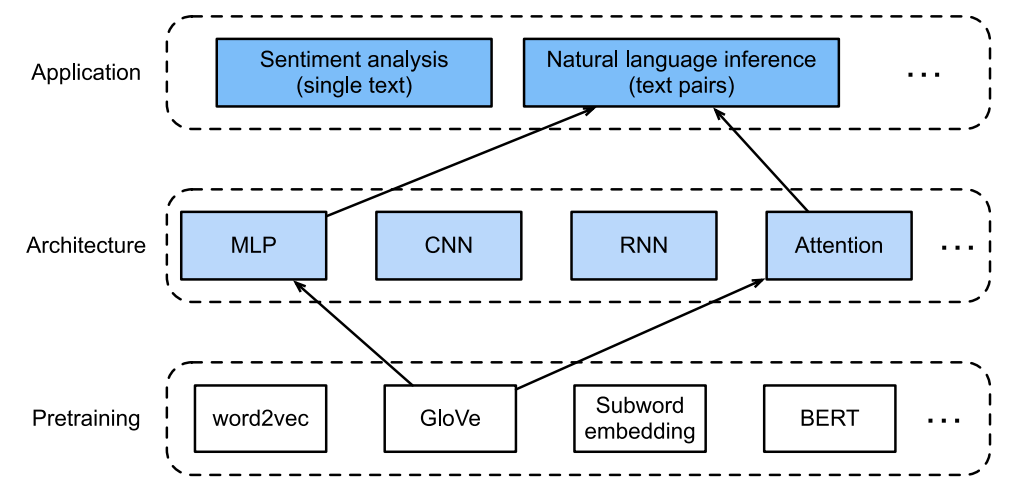

## 16.5.1 The Model

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

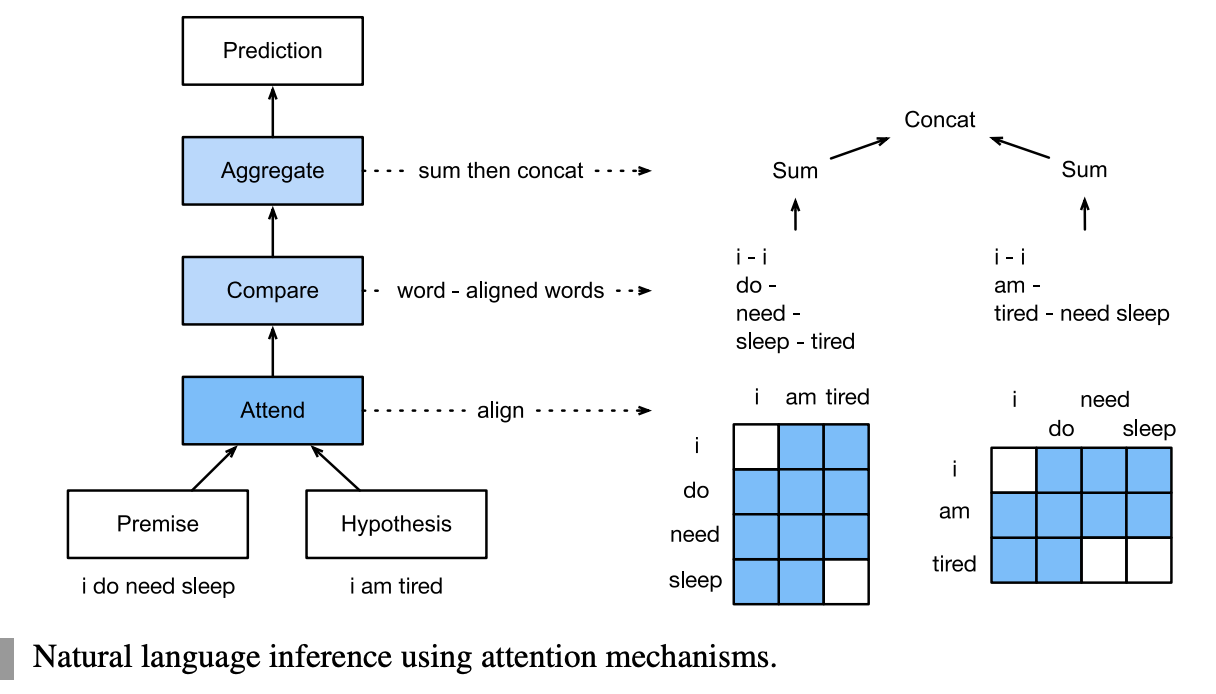

### Attending


The first step is to align tokens in one text sequence to each token in the other sequence. Suppose that the premise is “i do need sleep” and the hypothesis is “i am tired”. Due to semantical similarity, we may wish to align “i” in the hypothesis with “i” in the premise, and align “tired” in the hypothesis with “sleep” in the premise. Likewise, we may wish to align “i” in the premise with “i” in the hypothesis, and align “need” and “sleep” in the premise with “tired” in the hypothesis. Note that such alignment is soft using weighted average, where ideally large weights are associated with the tokens to be aligned. For ease of demonstration, Fig. 16.5.2 shows such alignment in a hard way.

Now we describe the soft alignment using mechanisms in more detail. Denote by $\mathbf{A} = (\mathbf{a}_1, ..., \mathbf{a}_m)$ and $\mathbf{B} = (\mathbf{b}_1, ..., \mathbf{b}_m)$ the premise and hypothesis, whose number of tokens are $m$ and $n$, respectively, where $\mathbf{a_j}, \mathbf{b_j} \in \mathbb{R}^d$ is a $d$-dimensional word vector. For soft alignment, we compute the attention weights $e_{ij} \in \mathbb{R}$ as:

$$

e_{ij} = f(\mathbf{a_i})^T f(\mathbf{b_j})

$$

where the function $f$ is an MLP defined in the following mlp function. The output dimension of $f$ is specified by the num_hiddens argument of mlp.

In [2]:
def mlp(num_inputs, num_hiddens, flatten):
    net = []
    net.append(nn.Dropout(0.2))
    net.append(nn.Linear(num_inputs, num_hiddens))
    net.append(nn.ReLU())
    if flatten:
        net.append(nn.Flatten(start_dim=1))
    net.append(nn.Dropout(0.2))
    net.append(nn.Linear(num_hiddens, num_hiddens))
    net.append(nn.ReLU())
    if flatten:
        net.append(nn.Flatten(start_dim=1))
    return nn.Sequential(*net)

In [3]:
class Attend(nn.Module):
    
    def __init__(self, num_inputs, num_hiddens, **kwargs):
        super(Attend, self).__init__(**kwargs)
        self.f = mlp(num_inputs, num_hiddens, flatten=False)

    def forward(self, A, B):
        # Shape of `A`/`B`: (`batch_size`, no. of tokens in sequence A/B,
        # `embed_size`)
        # Shape of `f_A`/`f_B`: (`batch_size`, no. of tokens in sequence A/B,
        # `num_hiddens`)
        f_A = self.f(A)
        f_B = self.f(B)
        # Shape of `e`: (`batch_size`, no. of tokens in sequence A,
        # no. of tokens in sequence B)
        e = torch.bmm(f_A, f_B.permute(0, 2, 1))
        # Shape of `beta`: (`batch_size`, no. of tokens in sequence A,
        # `embed_size`), where sequence B is softly aligned with each token
        # (axis 1 of `beta`) in sequence A
        beta = torch.bmm(F.softmax(e, dim=-1), B)
        # Shape of `alpha`: (`batch_size`, no. of tokens in sequence B,
        # `embed_size`), where sequence A is softly aligned with each token
        # (axis 1 of `alpha`) in sequence B
        alpha = torch.bmm(F.softmax(e.permute(0, 2, 1), dim=-1), A)
        return beta, alpha

### Comparing

In [4]:
class Compare(nn.Module):
    def __init__(self, num_inputs, num_hiddens, **kwargs):
        super(Compare, self).__init__(**kwargs)
        self.g = mlp(num_inputs, num_hiddens, flatten=False)
    def forward(self, A, B, beta, alpha):
        V_A = self.g(torch.cat([A, beta], dim=2))
        V_B = self.g(torch.cat([B, alpha], dim=2))
        return V_A, V_B

### Aggregating

In [5]:
class Aggregate(nn.Module):
    def __init__(self, num_inputs, num_hiddens, num_outputs, **kwargs):
        super(Aggregate, self).__init__(**kwargs)
        self.h = mlp(num_inputs, num_hiddens, flatten=True)
        self.linear = nn.Linear(num_hiddens, num_outputs)
    def forward(self, V_A, V_B):
        # Sum up both sets of comparison vectors
        V_A = V_A.sum(dim=1)
        V_B = V_B.sum(dim=1)
        # Feed the concatenation of both summarization results into an MLP
        Y_hat = self.linear(self.h(torch.cat([V_A, V_B], dim=1)))
        return Y_hat

### Putting It All Together

In [6]:
class DecomposableAttention(nn.Module):
    def __init__(self, vocab, embed_size, num_hiddens, num_inputs_attend=100,
                 num_inputs_compare=200, num_inputs_agg=400, **kwargs):
        super(DecomposableAttention, self).__init__(**kwargs)
        self.embedding = nn.Embedding(len(vocab), embed_size)
        self.attend = Attend(num_inputs_attend, num_hiddens)
        self.compare = Compare(num_inputs_compare, num_hiddens)
        # There are 3 possible outputs: entailment, contradiction, and neutral
        self.aggregate = Aggregate(num_inputs_agg, num_hiddens, num_outputs=3)
    def forward(self, X):
        premises, hypotheses = X
        A = self.embedding(premises)
        B = self.embedding(hypotheses)
        beta, alpha = self.attend(A, B)
        V_A, V_B = self.compare(A, B, beta, alpha)
        Y_hat = self.aggregate(V_A, V_B)
        return Y_hat

## 16.5.2 Training and Evaluating the Model

### Reading the dataset

In [7]:
batch_size, num_steps = 256, 50
train_iter, test_iter, vocab = d2l.load_data_snli(batch_size, num_steps)

read 549367 examples
read 9824 examples


### Creating the Model

In [8]:
embed_size, num_hiddens, devices = 100, 200, d2l.try_all_gpus()
net = DecomposableAttention(vocab, embed_size, num_hiddens)
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds);

### Training and Evaluating the Model

loss 0.496, train acc 0.805, test acc 0.828
6525.2 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1), device(type='cuda', index=2), device(type='cuda', index=3), device(type='cuda', index=4), device(type='cuda', index=5), device(type='cuda', index=6), device(type='cuda', index=7)]


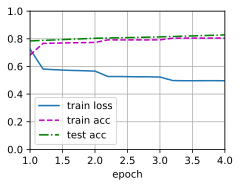

In [9]:
lr, num_epochs = 0.001, 4
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

### Using the Model

In [10]:
#@save
def predict_snli(net, vocab, premise, hypothesis):
    """Predict the logical relationship between the premise and hypothesis."""
    net.eval()
    premise = torch.tensor(vocab[premise], device=d2l.try_gpu())
    hypothesis = torch.tensor(vocab[hypothesis], device=d2l.try_gpu())
    label = torch.argmax(net([premise.reshape((1, -1)),
                           hypothesis.reshape((1, -1))]), dim=1)
    return 'entailment' if label == 0 else 'contradiction' if label == 1 \
else 'neutral'

In [11]:
predict_snli(net, vocab, ['he', 'is', 'good', '.'], ['he', 'is', 'bad', '.'])

'contradiction'